In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

import subprocess

# Utils

In [2]:
# lambdas
file_name = lambda algorithm: f'data/{algorithm}.csv'
get_result = lambda algorithm: pd.read_csv(file_name(algorithm))

In [3]:
# constant variables
M = 100
RANGE = np.arange(100, 10000, step=100)
INIT_DF = pd.DataFrame(columns=['array_size', 'comparisons', 'swaps'])

In [4]:
def execute_select(algorithm, n, k, **kwargs):
    subarr_size = kwargs.get('subarr_size', None)
    generate = subprocess.Popen(f'./generate.exe {n} random {k}'.split(), stdout=subprocess.PIPE)
    select_cmd = f'./select.exe {algorithm} {subarr_size}' if subarr_size else f'./select.exe {algorithm}'
    subprocess.Popen(select_cmd.split(), stdin=generate.stdout, stdout=subprocess.PIPE)
v_execute_select = np.vectorize(execute_select)

def execute_search(variant, n, k, **kwargs):
    generate = subprocess.Popen(f'./generate.exe {n} random {k}'.split(), stdout=subprocess.PIPE)
    subprocess.Popen(f'./search.exe {variant}'.split(), stdin=generate.stdout, stdout=subprocess.PIPE)
v_execute_search = np.vectorize(execute_search)

def execute_sort(how, n, k, **kwargs):
    use_select = kwargs.get('use_select', False)
    sort_cmd = f'./sort.exe {how} use-select' if use_select else f'./sort.exe {how}'
    generate = subprocess.Popen(f'./generate.exe {n} random none'.split(), stdout=subprocess.PIPE)
    subprocess.Popen(sort_cmd.split(), stdin=generate.stdout, stdout=subprocess.PIPE)
v_execute_sort = np.vectorize(execute_sort)

def run(v_execute, algorithm, size_range, m, k_gen, **kwargs):
    for n in size_range:
        A = np.full(shape=(m,), fill_value=algorithm)
        N = np.full(shape=(m,), fill_value=n)
        K = k_gen(n, m)
        v_execute(A, N, K, **kwargs)


def process_result(df, execution_time=False):
    if execution_time:
        df_cmp = pd.DataFrame(df.groupby('array_size', as_index=False)['comparisons'].mean())
        df_t = pd.DataFrame(df.groupby('array_size', as_index=False)['time'].mean())
        df = pd.merge(df_cmp, df_t, on='array_size')
        return df

    df_cmp = pd.DataFrame(df.groupby('array_size', as_index=False)['comparisons'].mean())
    df_swp = pd.DataFrame(df.groupby('array_size', as_index=False)['swaps'].mean())
    df = pd.merge(df_cmp, df_swp, on='array_size')
    df['total'] = df['comparisons'] + df['swaps']
    return df


def plot_results(results: dict, execution_time=False):
    fig = plt.figure(figsize=(15, 6))
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    if execution_time:
        axs = [plt.subplot2grid((1,2), (0,0), colspan=1, rowspan=1), 
               plt.subplot2grid((1,2), (0,1), colspan=1, rowspan=1)]
        plt.subplots_adjust(wspace=0.25)

        axs[0].set_title(f"Comparison count")
        axs[1].set_title(f"Executon time [s]")

        for (i, (algorithm, df)) in enumerate(results.items()):
            axs[0].plot(df['array_size'], df['comparisons'], color=colors[i], label=algorithm)
            axs[1].plot(df['array_size'], df['time'], color=colors[i], label=algorithm)

        axs[0].set_ylabel("$cmp(n)$")
        axs[1].set_ylabel("$T(n)$")

    else:
        axs = [plt.subplot2grid((1,3), (0,0), colspan=1, rowspan=1), 
               plt.subplot2grid((1,3), (0,1), colspan=1, rowspan=1), 
               plt.subplot2grid((1,3), (0,2), colspan=1, rowspan=1)]
        plt.subplots_adjust(wspace=0.25)

        axs[0].set_title(f"Comparison count")
        axs[1].set_title(f"Swaps count")
        axs[2].set_title(f"Total complexity")

        for (i, (algorithm, df)) in enumerate(results.items()):
            axs[0].plot(df['array_size'], df['comparisons'], color=colors[i], label=algorithm)
            axs[1].plot(df['array_size'], df['swaps'], color=colors[i], label=algorithm)
            axs[2].plot(df['array_size'], df['total'], color=colors[i], label=algorithm)

        axs[0].set_ylabel("$cmp(n)$")
        axs[1].set_ylabel("$swp(n)$")
        axs[2].set_ylabel("$cmp(n) + swp(n)$")

    for i in range(len(axs)):
        axs[i].set_xlabel("$n$ - array size")
        axs[i].legend()

    plt.show();

# Init necessary files

In [5]:
# Init .exe script files
# subprocess.run('g++ -o generate src/generate.cpp -std=c++2a'.split())
# subprocess.run('g++ -o select src/select.cpp -std=c++2a'.split())
# subprocess.run('g++ -o search src/search.cpp -std=c++2a'.split())
# subprocess.run('g++ -o sort src/sort.cpp -std=c++2a'.split())

# Run experiments

* Exercise 2: random vs median select

In [6]:
select_algs = np.array(['random', 'median'])
select_gen = lambda n, size: np.linspace(1, n + 1, size)
print('executing:')
for algorithm in select_algs:
    print(f' -> {algorithm}')
    # INIT_DF.to_csv(file_name(algorithm), index=False)
    # run(v_execute_select, algorithm, RANGE, M, select_gen)

executing:
 -> random
 -> median


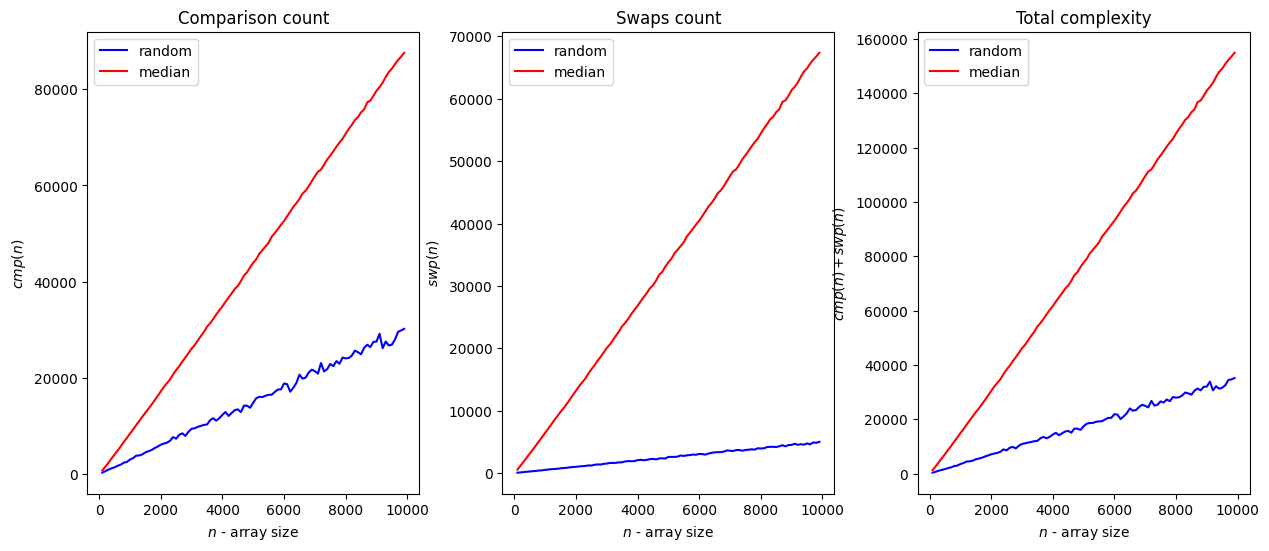

In [7]:
results = {a: get_result(a) for a in select_algs}
results = {a : process_result(results[a]) for a in results.keys()}
plot_results(results)

* Exercise 3: median select with varying subbarray size

In [8]:
subarr_sizes = np.array([3, 5, 7, 9])
print('executing:')
for size in subarr_sizes:
    print(f' -> median_{size}')
    # INIT_DF.to_csv(file_name(f'median_{size}'), index=False)
    # run(v_execute_select, 'median', RANGE, M, select_gen, subarr_size=size)

executing:
 -> median_3
 -> median_5
 -> median_7
 -> median_9


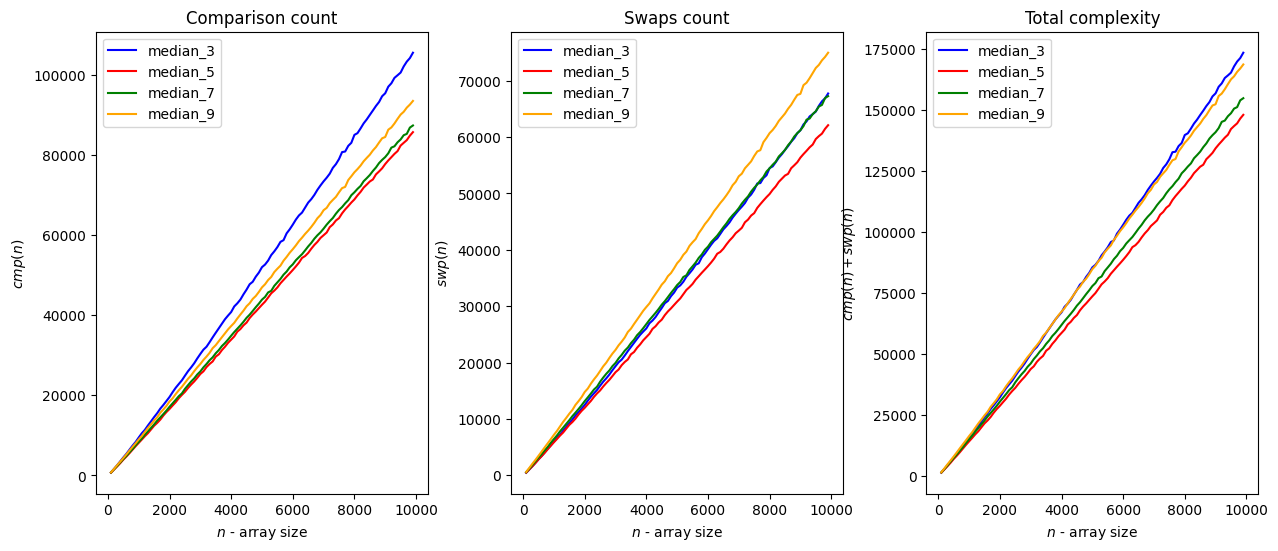

In [9]:
results = {s: get_result(s) for s in [f'median_{size}' for size in subarr_sizes]}
results = {s : process_result(results[s]) for s in results.keys()}
plot_results(results)

* Exercise 4: binary search complexity

In [10]:
search_df = pd.DataFrame(columns=['array_size', 'comparisons', 'time'])
k_variants = {
    'begin':    lambda n, size: np.random.randint(1, 2 * n / 100 * 5, size=size),
    'mid':      lambda n, size: np.random.randint(2 * n / 100 * 45, 2 * n / 100 * 55, size=size),
    'end':      lambda n, size: np.random.randint(2 * n / 100 * 95, 2 * n, size=size),
    'random':   lambda n, size: np.random.randint(2 * n, size=size)
}
print('executing:')
for (variant, gen) in k_variants.items():
    print(f' -> {variant}')
    # search_df.to_csv(file_name(f'search_{variant}'), index=False)                             
    # run(v_execute_search, variant, RANGE * 10, M, gen)

executing:
 -> begin
 -> mid
 -> end
 -> random


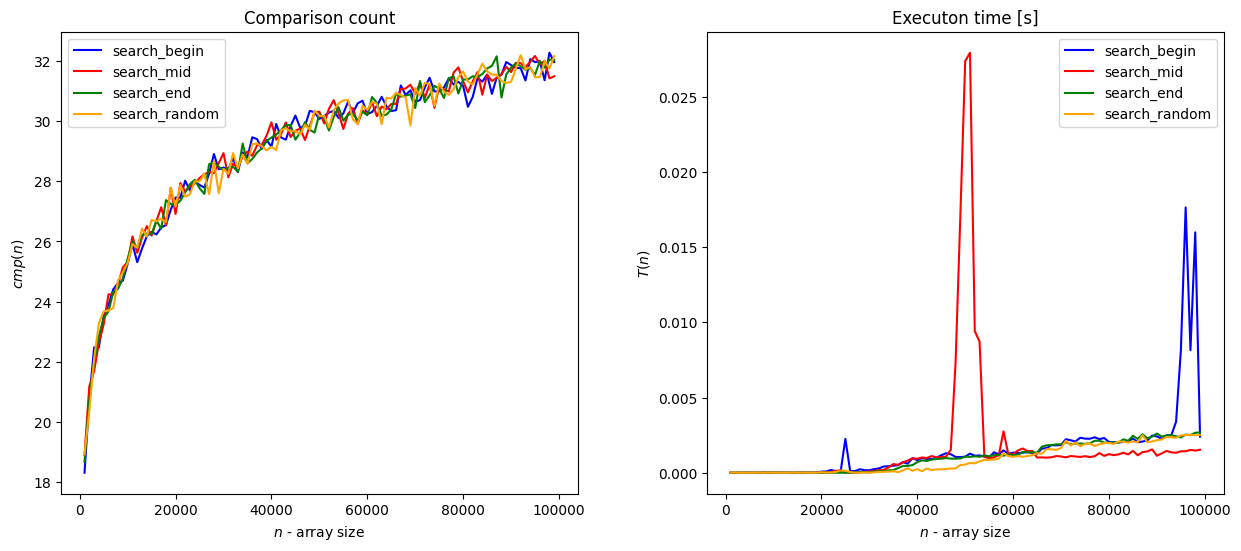

In [11]:
results = {v: get_result(v) for v in [f'search_{variant}' for variant in k_variants]}
results = {v : process_result(results[v], True) for v in results.keys()}
plot_results(results, True)

$O(1) \text{ factor } \approx 2.75$

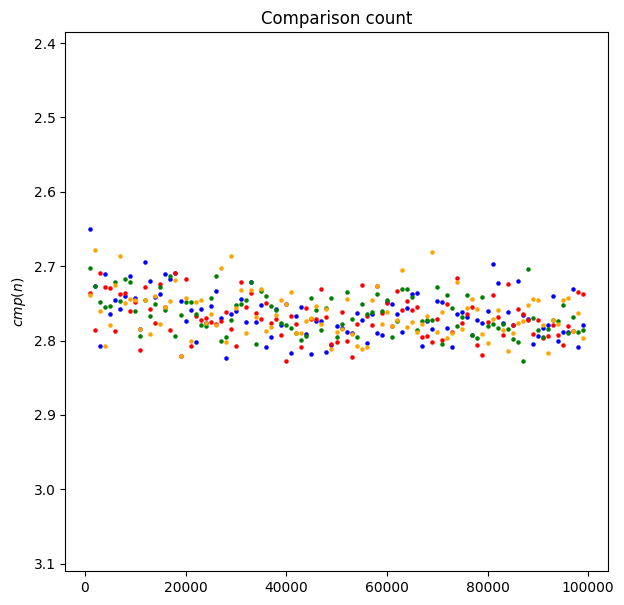

In [12]:
# Init data
results_const_factor = {}
for (variant, df) in results.items():
    df = df.copy()
    df['comparisons'] = df['comparisons'] / np.log(df['array_size'])
    results_const_factor[variant] = df


# Plot data
plt.figure(figsize=(7, 7))
plt.title(f"Comparison count")
plt.ylabel("$cmp(n)$")
y_lim = [max(df['comparisons'].max() for df in results_const_factor.values()) * 1.1,
         min(df['comparisons'].min() for df in results_const_factor.values()) * 0.9]
plt.ylim(y_lim)

colors = ['blue', 'red', 'green', 'orange', 'purple']
for (i, (algorithm, df)) in enumerate(results_const_factor.items()):
    plt.scatter(df['array_size'], df['comparisons'], color=colors[i], label=algorithm, s=5)

plt.show();

* Exercise 5: quick and dual pivot quick sorting algorithms with pivot selection

In [13]:
sort_file = lambda algorithm, use_select: f"sort_{algorithm}{'_select' if use_select else ''}"

sort_algs = list(itertools.product(['quick', 'dp_quick'], [False, True]))
for (algorithm, use_select) in sort_algs:
    print(f' -> {algorithm} {use_select}')
    # INIT_DF.to_csv(file_name(sort_file(algorithm, use_select)), index=False)
    # run(v_execute_sort, algorithm, RANGE, M, (lambda n, size: None), use_select=use_select)

 -> quick False
 -> quick True
 -> dp_quick False
 -> dp_quick True


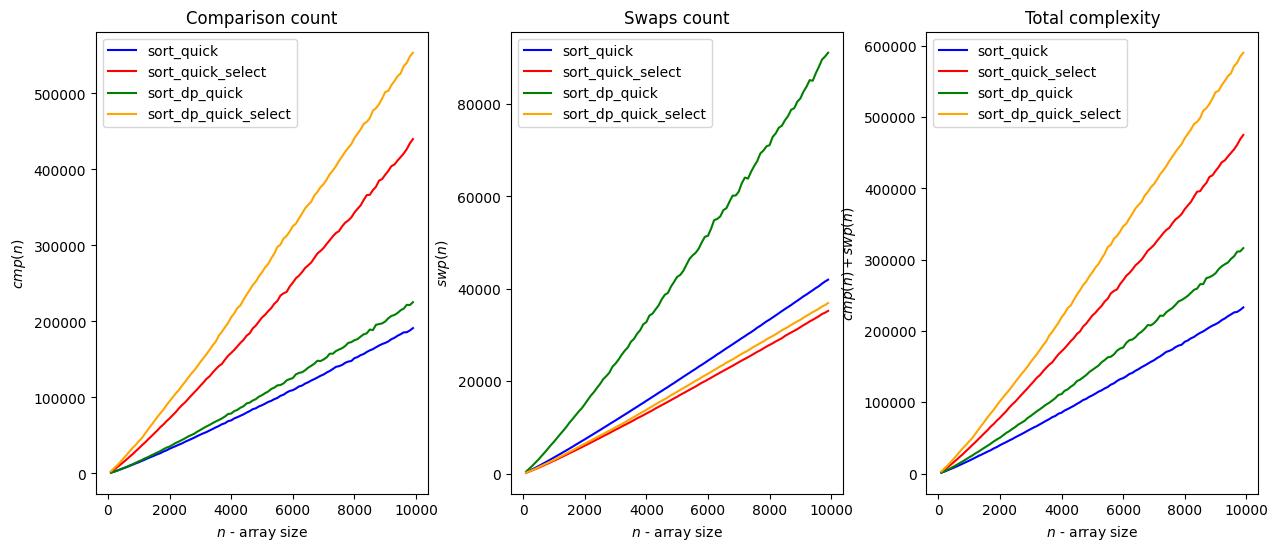

In [14]:
results = {s: get_result(s) for s in [sort_file(alg, select) for (alg, select) in sort_algs]}
results = {s : process_result(results[s]) for s in results.keys()}
plot_results(results)